Remember to run this!

This is required to import the required packages!

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import pickle
import json
from PIL import Image
import clip
from clip.model import AttentionPool2d
from clip.model import ModifiedResNet
from typing import Tuple, Union
from clip.model import CLIP
from clip.model import convert_weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In this section, the **RefCOCOg** dataset il loaded and the tree splits are generated:
- `training_data`: split used to train the model, length: **80512**
- `validation_data`: split used to validate the model during training, length: **4896**
- `test_data`: split used to test the model after training, length: **9602**

Total: **95010**

The splits include exactly all samples from the dataset. This generates a very big training dataset that, due to computational limits, cannot be effectively exploited to fine tune the model to perfection.
Notice that the images in the dataset are around **25000**. The dataset size however is this big since each prompt, associated to the same image has been treated as a separated sample.

> The path of the dataset must be adjusted based on the location of the dataset folder

In [31]:
# adjust based on the location of the dataset folder!
refcocog_path =  "E:/DL_Datasets/refcocog"

Load the pickle file and the instances json file

In [32]:
pick = pickle.load(open(refcocog_path+"/annotations/refs(umd).p", "rb"))
jsn = json.load(open(refcocog_path+"/annotations/instances.json", "rb"))

In [33]:
# set of all images
images_set = {}
for i in jsn['images']:
  image_id = i['id']
  images_set[image_id] = i

# set of all annotations
annotations_set = {}
for a in jsn['annotations']:
  annotation_id = a['id']
  annotations_set[annotation_id] = a

# set of all categories
# categories_set = {}
# for c in jsn['categories']:
#   category_id = c['id']
#   categories_set[category_id] = c

**Build dataset splits**

In [34]:
train_data, train_label       = [], []
validate_data, validate_label = [], []
test_data, test_label         = [], []

for p in pick:
    data_image_path = f"{refcocog_path}/images/{images_set[p['image_id']]['file_name']}"
    data_sentences = p['sentences']
    data_bbox = annotations_set[p['ann_id']]['bbox']

    data = []

    for s in data_sentences:
        sentence = s['sent']
        data.append([data_image_path, sentence, data_bbox])

    if p['split'] == 'train':
        train_data.extend(data)
    elif p['split'] == 'test':
        test_data.extend(data)
    elif p['split'] == 'val':
        validate_data.extend(data)

print(f"train {len(train_data)}, validation {len(validate_data)}, test {len(test_data)}")

train 80512, validation 4896, test 9602


**Display an image with a bounding box**

In [35]:
def view_image_with_bbox(image_path, prompt, bbox):
    image = Image.open(image_path).convert("RGB")
    image = np.asarray(image)

    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))

    cv2.rectangle(image, p1, p2, (0,255,255), 3)

    plt.imshow(image)
    plt.title(prompt)
    plt.show()

# Model

![Diagramma senza titolo.drawio-2.png](<attachment:Diagramma senza titolo.drawio-2.png>)

The architecture proposed, is inspired by the recent work: [Adapting CLIP For Phrase Localization Without Further Training](https://arxiv.org/abs/2204.03647) by _Jiahao Li, Greg Shakhnarovich, Raymond A. Yeh_.

In their paper, the goal was to adapt the **CLIP** model to phrase localization, without the need of any further training. This goal is a perfect starting point in order to adapt their solution to out phrase grounding task for the project.

To begin with, we have taken the "backbone" model from their repository: https://github.com/pals-ttic/adapting-CLIP.
The code borrowed includes the modification of the ResNet of CLIP in order to introduce, in the last layer, a spatial attention layer.
The goal is to adapt the CLIP model for phrase localization and, since CLIP effectively acts as an image and text embedder, there is the need to adapt the model to introduce spatial reasoning.
The steps are:
- Extract spatial features **mantaining their semantic meaning** (alignment with text)
- Compute the inner product with the text embedding, effectively generating a score map (heatmap)

-----

### Single stage model

Many proposed methods that attempts to perform transfer learning to phrase localization and grounding starting from famous conv networks such as Fast-RCNN or Mask-RCNN, implements a what is called **two step models** [2].

Two stage models entails the use of an external feature extractor such as a Convolutional neural network that usually performs object detection and is able to extract bounding boxes.
These candidates boxes are then fed to the CLIP image encoder and compared with the encoding of the prompt, outputting the box with the highest score.
These solutions have an important caveat: since the CLIP encoding is compared with the subimage composed of the bounding box only, spatial reasoning is not included into the model.

The proposed method can be instead considered a **one stage model**.
Apart from the performance that we were able to achieve, the model should in theory be able to convey the spatial reasoning into the box regressor.
As shown below, the CLIP model is slightly modified in order to include this feature. This is the reason why the model is able to infer the heatmaps with quite remarkable accuracy.


It is worth noticing that, although the heatmaps are extracted with the `ResNetHighResV2` model and fed into the `HeatmapToBox` regressor, the framework can be considered as a single stage. 
Both the models could be infact unified in order to provide a single interface. This has not been done in order to better delineate the original contribution of the paper and our contribution.
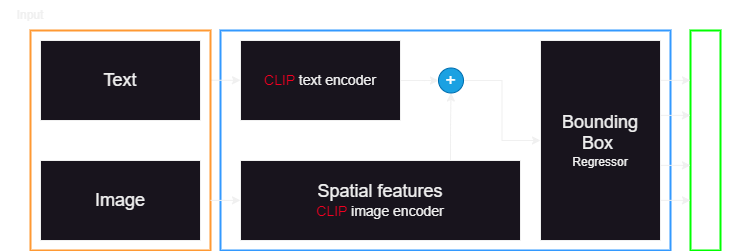

### Custom Spatial CLIP

In this cells, the code inspired from **Adapting CLIP For Phrase Localization Without Further Training** is introduced.
It includes the customized `AttentionSpatial2d` which basically introduces spatial attention.

The `ModifiedSpatialResNet` is a simple ResNet which includes the previously introduced `AttentionSpatial2d`.

Finally, the custom CLIP with the `ModifiedSpatialResNet` is defined.

The final method `build_feature_extractor_model` has the job of creating this customized CLIP and to enable **transfer learning** from CLIP by copying the relative weights into the custom model.

In [36]:
# load the CLIP model
clip_model, clip_preprocess = clip.load("RN50")

def linear(x, weight, bias):
    x = x.matmul(weight.t())
    x += bias
    return x

class AttentionSpatial2d(AttentionPool2d):
    """Edited attention pool layer to introduce spatial attention"""
    def __init__(self,
                 spacial_dim: int,
                 embed_dim: int,
                 num_heads: int,
                 output_dim: int = None):
        super().__init__(spacial_dim, embed_dim, num_heads, output_dim)

    def forward(self, x):
        n, c, h, w = x.shape
        x = x.reshape(n, c, h*w).permute(2, 0, 1) # NCHW -> (H*W)NC
        x = linear(x, self.v_proj.weight, self.v_proj.bias)
        x = linear(x, self.c_proj.weight, self.c_proj.bias)
        x = x.permute(1, 2, 0).reshape(n, -1, h, w) # (H*W)NC -> C(H*W)N -> (N, -1, H, W)
        return x

class ModifiedSpatialResNet(ModifiedResNet):
    """Modified resnet to include the edited attention pool layer"""
    def __init__(self,
                 layers,
                 output_dim,
                 heads,
                 input_resolution=224,
                 width=64):
        super().__init__(layers, output_dim, heads, input_resolution, width)

        self.attnpool = AttentionSpatial2d(
            input_resolution // 32, width * 32, heads, output_dim)

class CLIPSpatialResNet(CLIP):
    """Modified spatial CLIP including the spatial attention"""
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int):

        super().__init__(embed_dim, image_resolution, vision_layers, vision_width,
                         vision_patch_size, context_length, vocab_size,
                         transformer_width, transformer_heads, transformer_layers)

        # Override the visual model
        vision_heads = vision_width * 32 // 64
        self.visual = ModifiedSpatialResNet(layers=vision_layers,
                                            output_dim=embed_dim,
                                            heads=vision_heads,
                                            input_resolution=image_resolution,
                                            width=vision_width)

    def forward(self, image):
        image = image.type(self.dtype)

        # pad image
        pad = 64
        pad = (pad, pad, pad, pad)
        padded_image = F.pad(image, pad, "constant", 0)

        # get features
        features = self.encode_image(padded_image)
        target_size_h, target_size_w = image.size(-2) // 32, image.size(-1) // 32

        # compute new pad size
        pad_h = (features.size(-2) - target_size_w) // 2
        pad_w = (features.size(-1) - target_size_w) // 2
        features = features[:, :, pad_h:pad_h+target_size_h, pad_w:pad_w+target_size_w]

        # interpolate back to 224*224
        features = F.upsample(features, size=(image.size(-2), image.size(-1)),
            mode="bilinear", align_corners=None) # 1*C*H*W

        return features
    

def build_feature_extractor_model(clip_model): 
    """"Instantiate the modified CLIP model and adapt weights"""
    # transfer learning: extract weights from CLIP
    clip_state_dict = clip_model.state_dict()
    # run [k for k in clip_state_dict if k.startswith("visual.layer2")] to see what's up
    counts: list = [len(set(k.split(".")[2] for k in clip_state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
    vision_layers = tuple(counts)
    vision_width = clip_state_dict["visual.layer1.0.conv1.weight"].shape[0]
    output_width = round(
        (clip_state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)

    vision_patch_size = None
    image_resolution = output_width * 32

    embed_dim = clip_state_dict["text_projection"].shape[1]
    context_length = clip_state_dict["positional_embedding"].shape[0]
    vocab_size = clip_state_dict["token_embedding.weight"].shape[0]
    transformer_width = clip_state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(
        k.split(".")[2] for k in clip_state_dict if k.startswith(f"transformer.resblocks")))

    model = CLIPSpatialResNet(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers).to(device)

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in clip_state_dict:
            del clip_state_dict[key]

    convert_weights(model)

    # False for the average filter layer.
    model.load_state_dict(clip_state_dict, strict=False)
    # model.eval()
    if device == 'cpu':
        model.float()
    return model

### Feature Extractor

Here, the actual feature extractor model is created.
The `ResNetHighResV2` model is responsible for taking as input images and prompts, generating the scoremaps (heatmaps).

> The model has been adapted and customized (V2) in order to enable batch computation of heatmaps, since in the original implementation of the paper, the model was able to accept single image and prompt.

-----
Example of an image and its corresponding heatmap. Notice that the heatmaps is _shrinked_ and normalized to a fixed width and height, nonetheless spatial reasoning is mantained.

`the white imac computer that is also turned on`


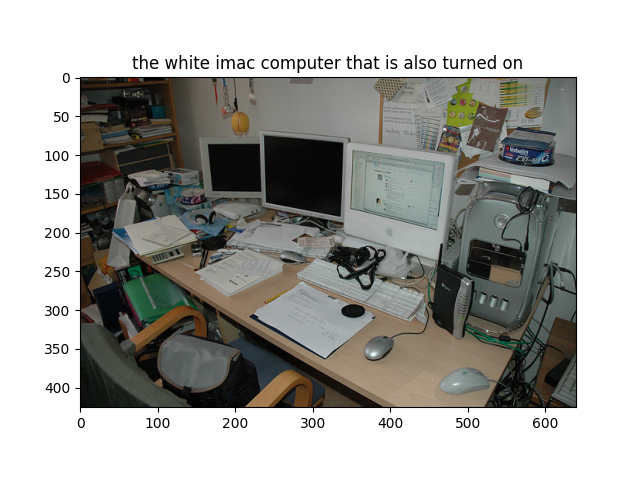 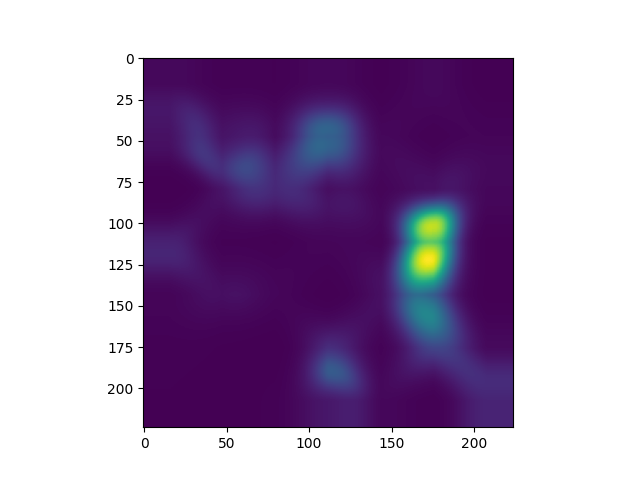

In [70]:
class ResNetHighResV2(nn.Module):
    """Feature extractor that includes CLIP as its fundation model"""
    def __init__(self, clip_preprocess, tokenize, temperature=0.1, remap_heatmaps=True):
        super().__init__()
        self.spatial_model = build_feature_extractor_model(clip_model)
        self.clip_preprocess = clip_preprocess
        self.tokenize = tokenize
        self.temperature = temperature
        self.remap_heatmaps=remap_heatmaps

    def get_image_features(self, images):
        images = [clip_preprocess(image) for image in images]
        images = torch.stack(images).to(device)
        image_features = self.spatial_model(images)
        return image_features

    def get_text_features(self, texts):
        tokenized_texts = self.tokenize(texts).to(device)
        text_features = self.spatial_model.encode_text(tokenized_texts)
        return text_features
    
    def get_heatmaps(self, image_features, text_features):
        image_features /= image_features.norm(dim=1, keepdim=True)
        text_features /= text_features.norm(dim=1, keepdim=True)
        heatmaps = (image_features * text_features[:, :, None, None]).sum(1)
        heatmaps = torch.exp(heatmaps/self.temperature)
        if self.remap_heatmaps:
            for i in range(len(heatmaps)):          
                min_ele = torch.min(heatmaps[i])
                heatmaps[i] -= min_ele
                heatmaps[i] /= torch.max(heatmaps[i])
        return heatmaps

    def forward(self, images, texts):
        image_features = self.get_image_features(images)
        text_features = self.get_text_features(texts)
        heatmaps = self.get_heatmaps(image_features, text_features)
        heatmaps = heatmaps.cpu().detach().float()
        return heatmaps


### Bounding Box regressor

The following model is the **head** of all of our framework.

It takes as input the heatmaps generated by `ResNetHighResV2` and regresses the four points of the bounding box in the form `(x, y, w, h)`.

It is worth noticing that this choice of a single bounding box regression without label is motivated by the fact that in the **RefCOCOg** dataset, each (image, prompt) is associated to a single bounding box.
Hence, since the job was to generate a phrase localization framework on the **RefCOCOg** dataset, the choice was to have a regressor that simply outputs a single box.

-----

The model effectively treats the heatmap as an image.

The first sequential layer is a series of `Conv2d` layers, that have the job to comprehend the spatial structure of the heatmap.

The second sequential layer is composed of an `AvgPool1d` that has the job to smooth the heatmap, followed by a **FFNN** that effectively regresses the four points.
In the first layer of the **FFNN**, `Dropout` layers have been introduced in order to randomly zeroes some of the elements of the input tensor with a certain probability using samples from a Bernoulli distribution.

This has been proven beneficial in the paper [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/abs/1207.0580) at the cost of slightly slowing down training time.

The weights initialization has been carried out by a dedicated function.

Initializing weights in a certain range, enables to ensure that no weights are outliers, effectively speeding up the initial convergence.

In [38]:
class HeatmapToBox(nn.Module):
    """Custom model to regress a bounding box from an heatmap"""
    def __init__(self):
        super().__init__()  
        self.conv = nn.Sequential(                            
            nn.Conv2d(1,1,8,stride=1), 
            nn.Conv2d(1,1,6,stride=2), 
            nn.Conv2d(1,1,4,stride=2)
            )
        self.seq = nn.Sequential(    
            nn.Flatten(),
            nn.AvgPool1d(4),

            nn.Linear(676, 256),
            nn.Dropout(p=0.05),            
            nn.Sigmoid(),            

            nn.Linear(256, 128),  
            #nn.Dropout(p=0.05),          
            nn.Sigmoid(),

            nn.Linear(128, 4),
            nn.Sigmoid(),          
        )       
        self.conv.apply(self.weights_init)
        self.seq.apply(self.weights_init)
        
    def weights_init(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0,  .75)
        if isinstance(m, torch.nn.BatchNorm1d):
            torch.nn.init.normal_(m.weight, 0.0, .75)
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.normal_(m.weight, 0.0, .75)
            
    def forward(self, x):   
        return self.seq(self.conv(x.unsqueeze(dim=1)))

# Training

Training is carried out uniquely on the head of the framework, that is the `HeatmapToBox` model. There is no fine tuning on the CLIP model and the reasons are explained below.

The choice of not introducing finetuning on the CLIP model or at least on some of its layers is that we wanted to analyze a possible different way of regressing the bounding box with respect to the one used in the original paper [Adapting CLIP For Phrase Localization Without Further Training](https://arxiv.org/abs/2204.03647).

The paper states that their goal is to adapt CLIP to phrase localization **without further training**. Thus, in order to have the possibility to compare the bounding box regression method, we decided to keep the underlying CLIP backbone as it is.

This of course, comes with some drawbacks. First of all, all the burden of training weights uniquely on the head. Since, due to computational power and time limits, the model cannot be extremely large and complicated, this can results in generally worst overall performance, adaptation and generalization capabilities.

**Intersection Over Union**

The following function from `torchvision` calculates a gradient friendly version of the [Generalized Intersection Over Union](https://giou.stanford.edu/) and treats it as a loss, meaning that the `torch.Tensor` result is reduced to a single float that represents the average value for all the bounding boxes.

Boxes are converted from the **RefCOCOg** format to the format required by `torchvision`.

In [46]:
from torchvision.ops import generalized_box_iou_loss
from torchvision.ops.boxes import box_convert

def iou(boxes1, boxes2) -> torch.Tensor:
    return generalized_box_iou_loss(box_convert(boxes1,in_fmt="xywh",out_fmt="xyxy"),box_convert(boxes2,in_fmt="xywh",out_fmt="xyxy"),reduction="mean")

**Training parameters**

In [74]:
train_size = 32
train_batch_size = 4
epochs = 512
mini_train_data = train_data[:train_size]

validation_size = 1024
validation_batch_size = 32
validation_module = 6
mini_val_data = validate_data[:validation_size]

test_size = 8
test_batch_size = 2
mini_test_data = test_data[:test_size]

### Routines
- Train
- Validation
- Test

In [80]:
def training_routine(model, loss_fn, feature_extractor, optimizer):
    model.train()
    epoch_loss =[]
    for i in range(0, train_size, train_batch_size):
        batch_data = mini_train_data[i:i+train_batch_size]

        images, target_boxes, prompts = [], [], []
        for image_path, prompt, box in batch_data:
            image = Image.open(image_path).convert("RGB")
            w, h = image.size
            correct_box = [
                box[0] / w,
                box[1] / h,
                (box[0] + box[2]) / w,
                (box[1] + box[3]) / h
            ]
            target_boxes.append(correct_box)
            images.append(image)            
            prompts.append(prompt)            

        target_boxes = torch.tensor(target_boxes)

        with torch.no_grad():
            heatmaps = feature_extractor(images, prompts)            
        heatmaps_tensor = torch.tensor(np.array(heatmaps))

        optimizer.zero_grad()
        prediction_boxes = model(heatmaps_tensor)
        loss = loss_fn(prediction_boxes, target_boxes)        
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    return sum(epoch_loss) / len(epoch_loss)

def validation_routine(model, loss_fn, feature_extractor):
    model.eval()
    epoch_loss = []
    giou = []
    print("running validation")
    for i in range(0, validation_size, validation_batch_size):
        batch_data = mini_val_data[i:i+validation_batch_size]
        images, target_boxes, prompts = [], [], []
        for image_path, prompt, box in batch_data:
            image = Image.open(image_path).convert("RGB")
            w, h = image.size

            correct_box = [
                box[0] / w,
                box[1] / h,
                (box[0] + box[2]) / w,
                (box[1] + box[3]) / h
            ]
            target_boxes.append(correct_box)
            images.append(image)            
            prompts.append(prompt)            

        target_boxes = torch.tensor(target_boxes)
        with torch.no_grad():
            heatmaps = feature_extractor(images, prompts)
            heatmaps_tensor = torch.tensor(np.array(heatmaps))
            prediction_boxes = model(heatmaps_tensor)

        loss = loss_fn(prediction_boxes, target_boxes)
        epoch_loss.append(loss.item())
        giou.append(iou(prediction_boxes, target_boxes))
    return sum(epoch_loss) / len(epoch_loss), sum(giou) / len(giou)

def test_routine(model, loss_fn, feature_extractor):
    model.eval()
    epoch_loss = []
    giou = []
    print("running test")
    for i in range(0, test_size, test_batch_size):
        batch_data = mini_test_data[i:i+test_batch_size]
        images, target_boxes, prompts = [], [], []
        for image_path, prompt, box in batch_data:
            image = Image.open(image_path).convert("RGB")
            w, h = image.size

            correct_box = [
                box[0] / w,
                box[1] / h,
                (box[0] + box[2]) / w,
                (box[1] + box[3]) / h
            ]
            target_boxes.append(correct_box)
            images.append(image)            
            prompts.append(prompt)            

        target_boxes = torch.tensor(target_boxes)
        with torch.no_grad():
            heatmaps = feature_extractor(images, prompts)
            heatmaps_tensor = torch.tensor(np.array(heatmaps))
            prediction_boxes = model(heatmaps_tensor)
        # for img, p, h in zip(images, prompts, heatmaps):
        #     plt.imshow(img)
        #     plt.title(p)
        #     plt.savefig(f'{p}.png')
        #     plt.show()
        #     plt.imshow(h)
        #     plt.savefig(f'{p}_h.png')
        #     plt.show()

        loss = loss_fn(prediction_boxes, target_boxes)
        epoch_loss.append(loss.item())
        giou.append(iou(prediction_boxes, target_boxes))
    return sum(epoch_loss) / len(epoch_loss), sum(giou) / len(giou)

### Training Cycle

In [57]:
feature_extractor = ResNetHighResV2(clip_preprocess, clip.tokenize, remap_heatmaps=False)
loss_fn = nn.MSELoss()
bboxer = HeatmapToBox()
optimizer = torch.optim.Adam(params=bboxer.parameters(), lr=1e-2)

In [ ]:
best = 1E3
for epoch in range(epochs):
    loss = training_routine(bboxer,loss_fn ,feature_extractor, optimizer)
    print(f"epoch {epoch}")
    print(f"training_loss: {loss}")
    if epoch != 0 and epoch % validation_module == 0:        
        val_loss, giou = validation_routine(bboxer, loss_fn, feature_extractor)
        if val_loss+giou < best:
            torch.save(bboxer.state_dict(), "checkpoint")
            print("saving checkpoint")
            best=val_loss+giou        
        print(f"validation loss: {val_loss}, giou: {giou}")                
optimizer.zero_grad(set_to_none=True)
torch.save(bboxer.state_dict(), "checkpoint")

### Testing

In [82]:
test_loss, test_giou = test_routine(bboxer, loss_fn, feature_extractor)
print(f"test average loss: {test_loss}, test average giou: {test_giou}")         

running test
test average loss: 0.3178173154592514, test average giou: 1.5387475490570068


# Bibliography
- [1] [Adapting CLIP For Phrase Localization Without Further Training](https://arxiv.org/abs/2204.03647)
- [2] [A Fast and Accurate One-Stage Approach to Visual Grounding](https://arxiv.org/abs/1908.06354)
- [3] [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/abs/1207.0580)
- [4] [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)